# 5D-SXDM tutorial

```{important}
If you are new to SXDM data treatment, start with the [4D-SXDM tutorial](https://id01-science.gitlab-pages.esrf.fr/id01-sxdm-utils/examples/4D-SXDM_tutorial-BLISS.html).
```

This notebook introduces basic exploration and preprocessing of **5D-SXDM** data obatined on beamline ID01 @ ESRF using the in-house developed library `sxdm`. 

**Requirements**:
* An ESRF single sign-on (SSO)
* Basic knowledge of [Jupyter notebooks](https://jupyter.org/)
* Intermediate knowledge of Python
* Having followed the [4D-SXDM tutorial](https://id01-science.gitlab-pages.esrf.fr/id01-sxdm-utils/examples/4D-SXDM_tutorial-BLISS.html)

```{warning}
This notebook deals with SXDM data produced by BLISS, the new control system of ESRF. BLISS is still under development and its structure changes relatively often. Some code in this notebook may therefore be out of date (as well as some info/explanations) and not work correctly. If this is the case, please submit an [issue](https://gitlab.esrf.fr/id01-science/id01-sxdm-utils/-/issues/new).
```

**Definitions**:

* **4D-SXDM** : two piezo motors of choice are raster scanned across a chosen area. At each point of the raster, a detector frame is recorded with a chosen exposure time. A 4D dataset results: `intensity(motor_1, motor_2, detector_x, detector_y)`.

* **5D-SXDM** : a set of 4D-SXDM scans taken at varying values of an additional motor, typically the incidence angle. A 5D dataset results: `intensity(motor_1, motor_2, detector_x, detector_y, extra_motor)`. If the `extra_motor` is the incidence angle, the 5D dataset corresponds to a rocking curve (3D reciprocal space map) being taken at each point of the raster scan.

## Inspect data

Import libraries:

In [1]:
import sxdm
import numpy as np
import matplotlib.pyplot as plt
import id01lib
import xrayutilities as xu
import os
import gif
import matplotlib as mpl
import h5py
import scipy.ndimage as ndi

from matplotlib.colors import LogNorm

  File "/gpfs/easy/data/id01/inhouse/data_analysis/software/pyenvs/sxdm.slurm/lib/python3.12/site-packages/silx/third_party/EdfFile.py", line 122, in <module>
    deprecated_warning(


Specify the experiment directory. This is normally `/data/visitor/<experiment_number>/<beamline>/<experiment_date>/`:

In [2]:
path_exp = os.path.abspath("./data/MA1234/id01/20230710/")

List its contents:

In [3]:
%ls {path_exp}

RAW_DATA/


Check the directories in `RAW_DATA`, normally each corresponding to a **sample**, and select one:

In [4]:
%ls {os.path.join(path_exp, "RAW_DATA")}

InGaN/


In [5]:
name_sample = "InGaN"

List the datasets measured for the selected sample name:

In [6]:
%ls {os.path.join(path_exp, "RAW_DATA", name_sample)}

InGaN_0001/


Select a **dataset** and specify its full path:

In [7]:
name_dset = "0001"

path_dset = f"{path_exp}/RAW_DATA/{name_sample}/{name_sample}_{name_dset}/{name_sample}_{name_dset}.h5"

*Optional* - Inspect interactively the SXDM maps contained in the selected dataset:

In [8]:
%matplotlib widget

viz = sxdm.widgets.bliss.InspectSXDMCounter(path_dset, default_counter="mpx1x4_mpx4int")
viz.show()

*Optional* - generata a gif of the SXDM maps contained in the dataset (useful for 5D-SXDM datasets):

In [9]:
sxdm.plot.gif_sxdm_sums(path_dset)

  0%|          | 0/5 [00:00<?, ?it/s]

Here the gif is saved in the same directory where this notebook is stored:

<img src="macro_InGaN_0001.h5_framesums.gif" alt="gif with sxdm sums" width="80%"/>

*Optional* - Inspect a single SXDM map in the dataset, looking at the scattered intensity interactively:

In [10]:
viz = sxdm.widgets.bliss.Inspect4DSXDM(path_dset, "1.1")
viz.show()

## Organise data in HDF5 files

Specify an **output directory** for the analysed data and generate it if does not exist.

In [11]:
path_out = f"{path_exp}/PROCESSED_DATA/{name_sample}_processed/"

try:
    os.makedirs(path_out)
except FileExistsError:
    print(f"Directory '{path_out}' already exists.")

Generate **xsocs-compatible** `.hdf5` data files in the output directory `path_out`. These files are required to perform subsequent analysis leveraging the capabilties of [XSOCS](https://kmap.gitlab-pages.esrf.fr/xsocs/), and contain only links to the raw data, not the data itself.


```{note}
This step will fail unless the selected dataset is a 5D-SXDM dataset.
```

In [12]:
# get the numbers of the SXDM scans in the dataset 
# not all of the scans in the dataset may be SXDM maps
scan_nos = sxdm.io.bliss.get_sxdm_scan_numbers(path_dset)

# feed the specified scans into the xsocs-files generating
# function
sxdm.utils.bliss.make_xsocs_links(
    path_dset, path_out, detector="mpx1x4", scan_nums=scan_nos
)

# specify the path to the "xsocs master file", i.e. a file
# that contains links to all other .hdf5 file
path_master = f"{path_out}/{name_sample}_{name_dset}_master.h5"

> Selecting scans 1.1 --> 5.1 in InGaN_0001
> Selecting detector mpx1x4
> Linking # 5.1/5.1 
> Done!



Sum all detector frames collected as part of each of the 4D-SXDM maps composing the 5D-SXDM dataset, and store this array as an `.npy` file on disk at `path_framesum`:

In [13]:
path_framesum = f"{path_out}/{name_dset}_framesum.npy"

frames_sum = sxdm.io.bliss.get_sxdm_frame_sum_multi(path_dset, path_save_framesum=path_framesum)

  0%|          | 0/5 [00:00<?, ?it/s]

*Optional* - The dimensions of `frames_sum` are thus: `(number_of_scans, detector_dimension_0, detector_dimension_1)`:

In [14]:
frames_sum.shape

(5, 516, 516)

## Mask detector frames

Generate a mask `mask_detector` for bad detector pixels. For this, sum `frames_sum` along the first dimension, `number_of_scans`, to obtain the the diffraction pattern averaged over all scans. Select the indexes of `mask_detector` and its intensity threshold appropriately - there is no general rule, as bad pixels may appear randomly during experiments.

Text(0.5, 1.0, 'Masked')

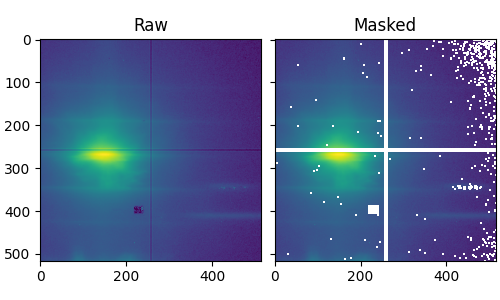

In [15]:
# select indexes and intensity thresold appropriately
mask_detector = np.zeros_like(frames_sum.sum(0), dtype="bool")
mask_detector[387:406, 217:241] = True
mask_detector[frames_sum.sum(0) > 1e7] = True
mask_detector[frames_sum.sum(0) <= 0] = True

fig, ax = plt.subplots(
    1, 2, sharey=True, sharex=True, layout="constrained", figsize=(5, 3)
)

ax[0].imshow(frames_sum.sum(0), norm=LogNorm())
ax[1].imshow(np.ma.masked_array(frames_sum.sum(0), mask=mask_detector), norm=LogNorm())

ax[0].set_title("Raw")
ax[1].set_title("Masked")

Apply the mask for each frame of the `frames_sum` array,

In [16]:
frames_sum_masked = np.ma.masked_array(
    frames_sum, mask_detector[None, ...] * np.ones_like(frames_sum)
)

## Compute reciprocal space coordinates

Sum `frames_sum` further along `detector_dimension_0` and `detector_dimension_1` to obtain a 1D array, here corresponding to a hypotethical rocking curve taken with a zero-dimensional detector. Identify the scan number corresponding to the probed Bragg peak, here the $025$:

[Text(2.1, 179176111.0, '2')]

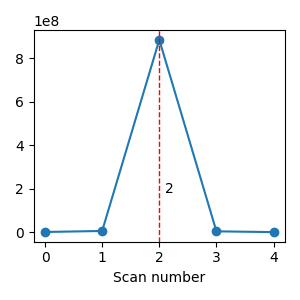

In [17]:
from scipy.signal import find_peaks

profile = frames_sum_masked.sum(axis=(1, 2))

peaks, _ = find_peaks(profile)

plt.figure(figsize=(3, 3), layout="tight")
plt.plot(profile, marker='o')
[plt.axvline(p, c="r", ls="--", lw=1) for p in peaks]
plt.xlabel("Scan number")
[plt.annotate(p, (p + 0.1, profile.mean())) for p in peaks]

{#calc-refl}
Specify the scan number established above as the location of the measured peak and,
* Load the **experimental** diffractometer angles for this scan;
* Calculate the **theoretical** diffractometer angles for the known peak index (here $025$) using a CIF file of the studied material;
* Calculate the **difference** between experimental and theoretical values (i.e. the angular offsets).

In [18]:
scan_no = "2.1"

# load angles from selected scan (= peak position)
angles_exp = {
    x: sxdm.io.bliss.get_positioner(path_dset, scan_no, x)
    for x in ["eta", "phi", "nu", "delta"]
}

# get incident beam energy in eV
nrj = id01lib.io.bliss.get_energy(path_dset, scan_no)

# compute theoretical values of angles and COMs in reciprocal space
angles_th, com_th = sxdm.utils.calc_refl_id01(
    [0, 2, 5],  # indexes of peak being probed
    xu.materials.GaN,  # material or CIF file
    [-1, 2, 0],  # in-plane direction (parallel to incident beam)
    [0, 0, 1],  # out-of-plane direction
    nrj,  
    return_q_com=True,
)

# additional angular offsets
d_eta, d_delta, d_rhy = [0, 0, 0]

# angular offsets dictionary
offsets = {
    "phi": angles_exp["phi"] - angles_th["phi"],
    "eta": angles_exp["eta"] - angles_th["eta"],
    "delta": angles_exp["delta"] - angles_th["delta"] + d_delta,
    "rhx": d_eta,
    "rhy": d_rhy,
}

Accounting for the angular offsets `offsets` established above, based on the measured diffractometer angles `angles_exp`, calculate the reciprocal space (q-space) coordinates for the 5D-SXDM dataset:

In [19]:
qx, qy, qz = id01lib.xrd.qspace.bliss.get_qspace_vals(
    path_dset,
    scan_nos,
    offsets=offsets,
    ignore_mpx_motors=True, 
)

Using cen_pix: row/y=256.169, col/x=138.845
Using det_dist = 0.94004 m
Using energy = 8.99971 keV
NOT correcting the central pixel for mpxy=-14.0, mpxz=0.0
------------------
Subtracting 0.001 from eta
Subtracting -6.135 from phi
Subtracting 0.533 from delta


```{attention}
Angular offsets are always **subtracted** from experimental values. A _negative_ offsets will therefore be _added_ to the experimentally measured angle.
```

Compute the centre of mass of the array `frames_sum` q-space, i.e. the experimental position of the peak in reciprocal space. Compare this with its theoretical position:

In [20]:
com_exp = [
    x for x in sxdm.process.math.calc_com_3d(frames_sum_masked, qx, qy, qz, n_pix=100)
]

print("\nTheo: ", [float(f"{x:.4f}") for x in com_th])
print("Exp : ", [float(f"{x:.3f}") for x in com_exp])
print("\ndiff: ", [float(f"{x:.4f}") for x in com_exp - com_th])


Theo:  [3.9405, -2.2751, 6.0578]
Exp :  [3.957, -2.301, 6.035]

diff:  [0.0167, -0.0259, -0.023]


/gpfs/easy/data/id01/inhouse/data_analysis/software/pyenvs/sxdm.slurm/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: UserWarning: Warning: 'argpartition' will ignore the 'mask' of the MaskedArray.
  return bound(*args, **kwds)


you can adjust the angular offsets to minimise this differences by changing the values of `d_eta`, `d_delta`, `d_rhy` above.

```{caution}
The q-space coordinates `qx`, `qy`, `qz` are computed via a linear combination of the measured diffractometer angles. Depending on the exact peak indexes, the `d_eta`, `d_delta`, `d_rhy` offsets which operate on those angles will therefore impact the position of the peaks all q-space directions, albeit not with the same magnitude.
```

Note that the theoretical peak position is computed based on the data published in the selected CIF file, so discrepancies with the experimental data may arise not only because of diffractometer/detector misalignments (which is what one is trying to account for here), but because of real structural differences between samples (e.g. strain).

This is the case here were we are looking at an InGaN crystal usign the GaN cif.

Inspect the location of the experimental (RED) and theoretical (BLUE) centre of mass:

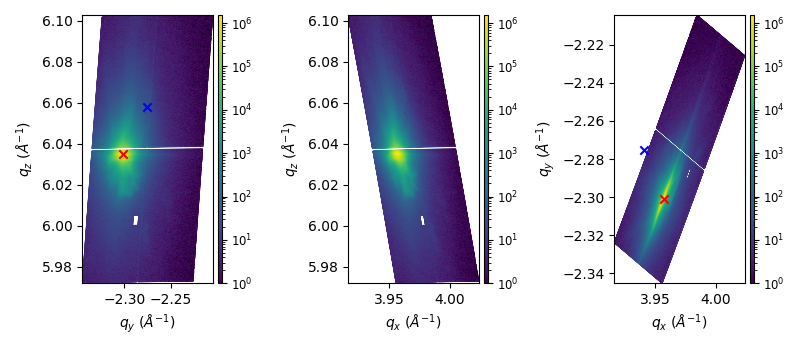

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(8, 3.5), dpi=100)

idx = int(scan_no.split(".")[0])

axs[0].pcolormesh(
    qy[idx, ...],
    qz[idx, ...],
    frames_sum_masked[idx, ...],
    norm=LogNorm(),
    shading="gouraud",
)
axs[1].pcolormesh(
    qx[idx, ...],
    qz[idx, ...],
    frames_sum_masked[idx, ...],
    norm=LogNorm(),
    shading="gouraud",
)
axs[2].pcolormesh(
    qx[idx, ...],
    qy[idx, ...],
    frames_sum_masked[idx, ...],
    norm=LogNorm(),
    shading="gouraud",
)

[axs[i].set_ylabel(r"$q_z$ ($\AA^{-1}$)") for i in (0, 1)]
[axs[i].set_xlabel(r"$q_x$ ($\AA^{-1}$)") for i in (1, 2)]

axs[0].set_xlabel(r"$q_y$ ($\AA^{-1}$)")
axs[2].set_ylabel(r"$q_y$ ($\AA^{-1}$)")

axs[0].scatter(com_exp[1], com_exp[2], marker="x", c="r")
axs[0].scatter(com_th[1], com_th[2], marker="x", c="b")

axs[2].scatter(com_exp[0], com_exp[1], marker="x", c="r")
axs[2].scatter(com_th[0], com_th[1], marker="x", c="b")

for ax in axs:
    sxdm.plot.add_colorbar(ax, ax.get_children()[0])

fig.tight_layout()

## Correct for sample drifts

Retrieve the maps of a counter appropriate to track sample drift over the 5D-SXDM measurement. Ideally the map of a marker using a fluorescence counter should be used. In this case this was not available, and the full detector intensity `mpx1x4_mpx4int` is used:

In [22]:
sxdm_raw = [sxdm.io.bliss.get_counter_sxdm(path_dset, s, "mpx1x4_mpx4int") for s in scan_nos]

Calculate the shift of the 4D-SXDM maps relative to eachother to estimate the drift (note - a mask can be supplied to `get_shift` if needed):

  0%|          | 0/4 [00:00<?, ?it/s]

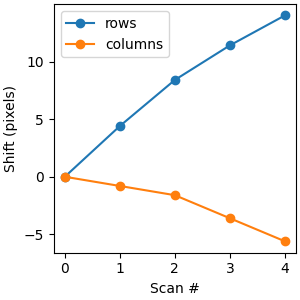

In [23]:
mask = np.zeros(sxdm.io.bliss.get_scan_shape(path_dset, "1.1")).astype("bool")

shifts = sxdm.utils.get_shift(
    sxdm_raw,
    upsample_factor=5,
)

plt.figure(figsize=(3, 3), layout="constrained")
plt.plot(shifts[:, 0], label="rows", marker="o")
plt.plot(shifts[:, 1], label="columns", marker="o")
plt.xlabel("Scan #")
plt.ylabel("Shift (pixels)")
plt.legend();

Apply the shift to the 4D-SXDM counter,

In [24]:
sxdm_shift = [ndi.shift(m, s, cval=np.nan) for m, s in zip(sxdm_raw, shifts)]

And visualise the results by making a gif. If the drift has been estimated correctly, features should not move as a function of scan index (i.e. angle).

In [25]:
@gif.frame
def plotit(i):
    fig, ax = plt.subplots(1, 1, layout="tight", figsize=(3, 3))
    im = ax.imshow(sxdm_shift[i], origin="lower")

    _data = im.get_array()
    _clims = [_data[_data.nonzero()].min(), _data.max()]
    _ = im.set_norm(mpl.colors.Normalize(_clims[0], _clims[1]))

    ax.set_title(f"Scan number: {i}/{len(scan_nos)}")
    ax.axhline(53, c="k", lw=0.7, ls="--")
    ax.axvline(30, c="k", lw=0.7, ls="--")


frames = [plotit(s) for s in range(len(sxdm_raw))]
gif.save(frames, "shift.gif", duration=200)

![click to see gif](./shift.gif)

```{tip}
If there is no counter that allows you to follow the sample drift properly in an automatic manner, you can do it manually by using `sxdm.widgets.bliss.GetShift`.
```

If drifts are measured, shift the raw data based on the estimated `shifts`. 
> This can take up to 40 minutes on a 40 core machine, depending on the size of the dataset. In the case of this sample data, it takes ~15 minutes.

In [26]:
%%time

sxdm.process.xsocs.shift_xsocs_data(path_master, path_out, shifts)

path_master_shifted = f"{path_out}/{name_sample}_{name_dset}_master_shifted.h5"

Using subh5_list=None, shifting file pattern /home/esrf/zatterin/repos/id01-sxdm-utils/doc/source/examples/data/MA1234/id01/20230710/PROCESSED_DATA/InGaN_processed//InGaN_0001*.1.h5 !


>> Shifting #2.1... chunk size (3, np.int64(172), np.int64(172))
>> Shifting #1.1... chunk size (3, np.int64(172), np.int64(172))
>> Shifting #3.1... chunk size (3, np.int64(172), np.int64(172))
>> Shifting #4.1... chunk size (3, np.int64(172), np.int64(172))



>> Shifting #5.1... chunk size (3, np.int64(172), np.int64(172))


InGaN_0001_1.1.h5 finished after 0.18m. I/O time: 0.18m

InGaN_0001_5.1.h5 finished after 1.27m. I/O time: 0.18m

InGaN_0001_4.1.h5 finished after 1.31m. I/O time: 0.18m

InGaN_0001_3.1.h5 finished after 1.38m. I/O time: 0.19m

InGaN_0001_2.1.h5 finished after 1.47m. I/O time: 0.18m
CPU times: user 81.7 ms, sys: 393 ms, total: 475 ms
Wall time: 1min 28s


## Interpolate data to reciprocal space

Estimate the maximum number of bins that can be used to perform the linear transformation from angular to (orthonormal) reciprocal space:

In [27]:
_maxbins = sxdm.process.xsocs.estimate_n_bins(path_master, offsets=offsets)
print(f"\n > Max n of bins: {_maxbins}")

Using cen_pix: row/y=256.169, col/x=138.845
Using det_dist = 0.94004 m
Using energy = 9.00001 keV
Subtracting 0.001 from eta
Subtracting -6.135 from phi
Subtracting 0.533 from delta

 > Max n of bins: [9, 15, 11]


Specify the path to the file that will contain the 5D q-space data:

In [28]:
path_qspace = f"{path_out}/qspace.h5"

Perform the linear transformation from angular to orthonormal reciprocal (q-) space for the full 5D-SXDM dataset. Specify an appropriate number of bins based on `maxbins`. Do not exceed 100 in any dimension.

In [29]:
%%time

try:
    sxdm.process.xsocs.grid_qspace_xsocs(
        path_qspace,
        path_master_shifted,
        [9, 15, 11],  # <-- specify number of bins here
        overwrite=False,
        offsets=offsets,
        mask=mask_detector,
        coordinates="cartesian",
    )
except RuntimeError:
    print("> Data exists! Set overwrite=True if needed.\n")

Subtracting 0.001 from eta
Subtracting -6.135 from phi
Subtracting 0.533 from delta
Process 1 started.Process 6 started.Process 3 started.Process 0 started.
Process 4 started.
Process 12 started.Process 13 started.Process 5 started.Process 7 started.Process 14 started.Process 11 started.Process 20 started.Process 8 started.Process 17 started.Process 15 started.Process 18 started.Process 2 started.Process 9 started.Process 10 started.
Process 27 started.Process 22 started.Process 19 started.Process 24 started.Process 16 started.
Process 31 started.Process 21 started.Process 29 started.Process 28 started.Process 23 started.
Process 30 started.Process 32 started.

Process 37 started.
Process 26 started.




Process 25 started.Process 36 started.Process 34 started.
Process 35 started.Process 33 started.






















#0/3600

#100/3600
#200/3600
#300/3600
#400/3600
#500/3600
#600/3600
#700/3600
#800/3600
#900/3600
#1000/3600
#1100/3600
#1200/3600
#1300/3600
#1400/3600
#1500/3600
#1

## Determine a VOI

The file `path_qspace` contains the data required for any subsequent analysis, i.e. the scattered intensity as a function of sample $(x, y)$ and reciprocal space $(q_x, q_y, q_z)$ coordinates, for the moment as a 4D dataset as $x$ and $y$ are flattened out:

$$ I(x*y, q_x, q_y, q_z) $$

In [30]:
with h5py.File(path_qspace) as h5f:
    print(h5f["Data/qspace"].shape)

(3600, 9, 15, 11)


Note that $(q_x, q_y, q_z)$ have the dimensions of the number of bins specified in the function `sxdm.process.xsocs.grid_qspace_xsocs`. 

In [31]:
qx, qy, qz = sxdm.utils.get_qspace_coords(path_qspace)

for q in (qx, qy, qz):
    print(q.shape)

(9,)
(15,)
(11,)


Now, compute the average 3D diffraction pattern by integrating the dataset along $(x, y)$:

In [32]:
qspace_avg = sxdm.io.xsocs.get_qspace_avg(path_qspace)

  0%|          | 0/40 [00:00<?, ?it/s]

Plot it and check the position of the experimental and theoretical COM as done before,

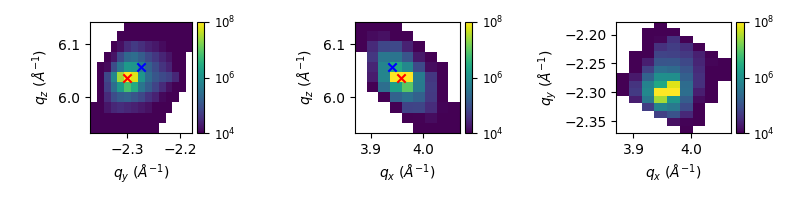

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(8, 2), layout="tight")

qxg, qyg, qzg = np.meshgrid(qx, qy, qz, indexing="ij")
cxg, cyg, czg = sxdm.process.math.calc_com_3d(qspace_avg, qxg, qyg, qzg)

_qext = sxdm.utils.get_q_extents(qx, qy, qz)
for i in range(3):
    ax[i].imshow(
        qspace_avg.sum(i).T,
        extent=_qext[i],
        origin="lower",
        aspect="equal",
        norm=LogNorm(1e4, 1e8),
    )
    cbar = sxdm.plot.add_colorbar(ax[i], ax[i].get_images()[0], size="7%")

ax[0].scatter(cyg, czg, marker="x", c="r")
ax[1].scatter(cxg, czg, marker="x", c="r")

ax[0].scatter(com_th[1], com_th[2], marker="x", c="b")
ax[1].scatter(com_th[0], com_th[2], marker="x", c="b")

ax[0].set_xlabel(r"$q_y~(\AA^{-1})$")
ax[2].set_ylabel(r"$q_y~(\AA^{-1})$")

for i in (1, 2):
    ax[i].set_xlabel(r"$q_x~(\AA^{-1})$")

for i in (0, 1):
    ax[i].set_ylabel(r"$q_z~(\AA^{-1})$")

Specify a boolean mask of the same shape as `qspace_avg` to restrict subsequent computations of intensity and COM to locations where the mask is equal to `True`. Here it is automatically computed as a box based on the position of the experimental COM expressed in pixel coordinates, and is defined so as to exclude the central peak to focus on the diffuse scattering around it:

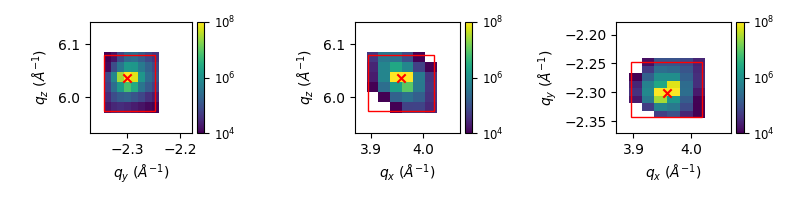

In [36]:
cxp, cyp, czp = [
    int(x)
    for x in sxdm.process.math.calc_com_3d(
        qspace_avg, *np.indices(qspace_avg.shape), n_pix=None
    )
]

mask_reciprocal = np.zeros(qspace_avg.shape).astype("bool")
mask_reciprocal[cxp - 2 : cxp + 4, cyp - 3 : cyp + 5, czp - 2 : czp + 4] = True
# mask_reciprocal[cxp : cxp + 3, cyp : cyp + 2, :] = False

mask_reciprocal = ~mask_reciprocal

roi = np.where(np.invert(mask_reciprocal))
roi_idxs = [(x.min(), x.max() + 1) for x in roi]
roi_slice = tuple([slice(x.min(), x.max() + 1) for x in roi])
roi_qcoords = [q[roi_slice] for q in np.meshgrid(qx, qy, qz, indexing="ij")]

qspace_avg_masked = np.ma.masked_array(data=qspace_avg, mask=mask_reciprocal)
qspace_avg_sliced = qspace_avg[roi_slice]

# Visualise the masked `qspace_avg`:
from matplotlib.patches import Rectangle as R

fig, ax = plt.subplots(1, 3, figsize=(8, 2), layout="tight")

_roi = [y for x in roi_qcoords for y in [x.min(), x.max()]]
r2 = R(
    (_roi[0], _roi[2]),
    _roi[1] - _roi[0],
    _roi[3] - _roi[2],
    edgecolor="r",
    facecolor="none",
    transform=ax[2].transData,
)  # xy
r1 = R(
    (_roi[0], _roi[4]),
    _roi[1] - _roi[0],
    _roi[5] - _roi[4],
    edgecolor="r",
    facecolor="none",
    transform=ax[1].transData,
)  # xz
r0 = R(
    (_roi[2], _roi[4]),
    _roi[3] - _roi[2],
    _roi[5] - _roi[4],
    edgecolor="r",
    facecolor="none",
    transform=ax[0].transData,
)  # yz

_qext = sxdm.utils.get_q_extents(qx, qy, qz)
for i, r in zip(range(3), [r0, r1, r2]):
    ax[i].imshow(
        qspace_avg_masked.sum(i).T,
        extent=_qext[i],
        origin="lower",
        aspect="equal",
        norm=LogNorm(1e4, 1e8),
    )
    ax[i].add_patch(r)
    cbar = sxdm.plot.add_colorbar(ax[i], ax[i].get_images()[0], size="7%")

ax[0].set_xlabel(r"$q_y~(\AA^{-1})$")
ax[2].set_ylabel(r"$q_y~(\AA^{-1})$")

for i in (1, 2):
    ax[i].set_xlabel(r"$q_x~(\AA^{-1})$")

for i in (0, 1):
    ax[i].set_ylabel(r"$q_z~(\AA^{-1})$")

for a, c in zip(ax, [(cyg, czg), (cxg, czg), (cxg, cyg)]):
    a.scatter(*c, marker="x", c="r")

## Extract local structural parameters

Compute the COM of the intensity in $(q_x, q_y, q_z)$ coordinates for each $(x*y)$ position of the 5D-SXDM map. The computation is limited to the $(q_x, q_y, q_z)$ sub-volume determined by `mask_reciprocal` and uses only the `n_pix` most intense pixels in the q-space array (use `n_pix=None` to use all the pixels):

In [37]:
cx_flat, cy_flat, cz_flat = sxdm.process.math.calc_coms_qspace3d(
    path_qspace, mask_reciprocal, n_pix=100
)

  0%|          | 0/3600 [00:00<?, ?it/s]

Alternatively, instead of calculating the COM, a Gaussian can be fitted to the $(q_x, q_y, q_z)$ projections of the sub-volume determined by `mask_reciprocal` using XSOCS:

In [38]:
from xsocs.process.fit import PeakFitter, FitTypes, BackgroundTypes
from xsocs.io.FitH5 import FitH5

# initialise fit object
fitter = PeakFitter(
    path_qspace,
    fit_type=FitTypes.GAUSSIAN,
    n_proc=os.cpu_count(),
    roi_indices=roi_idxs,
    background=BackgroundTypes.SNIP,
)

# run the processing and get the results
results = fitter.peak_fit() # <-- this is the time demanding step

# check for errors
if fitter.status != fitter.DONE:
    print("Fit process failed")
    sys.exit()

headers = ['sample_x', 'sample_y']
values = [results.sample_x, results.sample_y]

for dimension, axis_name in enumerate(results.qspace_dimension_names): # qx, qy, qz
    for parameter_name in results.available_result_names: # Area, Center, Sigma, Status
        headers.append(axis_name + '_' + parameter_name)
        values.append(results.get_results(dimension, parameter_name))

# transpose values from (parameters x points) to (points x parameters)
values = np.array(values).T

# make dict of results
res = {headers[i]:values[...,i] for i in range(len(headers))}

# reduce dict to only relevant data
names = [[f'q{m}_Area', f'q{m}_Center', f'q{m}_Sigma'] for m in 'x,y,z'.split(',')]
fits_gauss = {n[0].split('_')[0]:np.vstack([res[m].flatten() for m in n]).T for n in names}

# get the local q vector coordinates fromt the fits
cx_flat, cy_flat, cz_flat = [np.vstack(f)[..., 1] for f in fits_gauss.values()]

Compute the intensity integrated along $(q_x, q_y, q_z)$ within `mask_reciprocal` for each $(x*y)$ position of the 5D-SXDM map:

In [39]:
roi_int_flat = sxdm.process.math.calc_roi_sum(path_qspace, mask_reciprocal)

  0%|          | 0/40 [00:00<?, ?it/s]

Load the coordinates of the piezo stage,

In [40]:
pix, piy = sxdm.io.bliss.get_piezo_motor_positions(path_dset, "1.1")

Make a mask based on the calculated shifts and apply it to the computed COMs and intensity:

In [41]:
# shift indexes
r0, r1 = int(np.round(shifts[:, 0].max())), int(np.round(shifts[:, 0].min()))
c0, c1 = int(np.round(shifts[:, 1].max())), int(np.round(shifts[:, 1].min()))

# non-shifting window
pi_win = np.s_[r0 : r1 if r1 != 0 else None, c0 : c1 if c1 != 0 else None]

# SXDM map shape
map_sh = sxdm.io.bliss.get_scan_shape(path_dset, "1.1")

# mask COMs and intensity
mask_direct = np.ones(map_sh)
mask_direct[pi_win] = 0

roi_int, cx, cy, cz = [
    np.ma.masked_where(mask_direct != 0, x.reshape(map_sh))
    for x in (roi_int_flat, cx_flat, cy_flat, cz_flat)
]

_Optional_ - Mask the images based on the scattered intensity:

In [42]:
# from skimage import filters

# th = filters.threshold_mean(roi_int)
# mask_direct = (roi_int < th)
# cx, cy, cz = [np.ma.masked_array(c, mask_direct) for c in (cx, cy, cz)]

Calculate strain and tilt,

In [43]:
# Local q-vector and its magnitude
Q = np.array([cx, cy, cz]).reshape(3, np.prod(cx.shape))
q = np.sqrt(cx**2 + cy**2 + cz**2)

# reference COM
# cx0, cy0, cz0 = cxg, cyg, czg # mean without mask (from qspace_avg)
cx0, cy0, cz0 = cx.mean(), cy.mean(), cz.mean() # mean with mask

# average q-vector and its magnitude
Q_av = np.array([cx0, cy0, cz0])
q_av = np.sqrt(cx0**2 + cy0**2 + cz0**2)

# local q-vector position in spherical coordinates (inclincation and azimuth)
inc_rel = np.degrees(np.arccos(np.dot(Q_av, Q).reshape(q.shape) / (q * q_av)))
azi_rel = np.degrees(np.arctan2(cx - cx0, cy - cy0))

# interplanar distance, strain, and tilt
d = 2 * np.pi / q
strain = (q - q.mean()) / q.mean()
tilt = sxdm.plot.make_hsv(inc_rel, 180 + azi_rel)

Specify crystal directions based on what specified in the [computation of reciprocal space coordinates](#calc-refl):

In [44]:
crystal_directions = [
    r"$[\overline{1}00]$",  #  || qy
    r"$[\overline{1}20]$",  #  || qx (parallel to incident beam at zero angles)
    r"[100]",  #  || -qy
    r"$[1\overline{2}0]$",  #  || -qx
]
crystal_directions.append(crystal_directions[0])

In [45]:
peak_index = '025'

Note:

In [46]:
print(offsets["phi"])

-6.134875000000001


### Summary plot

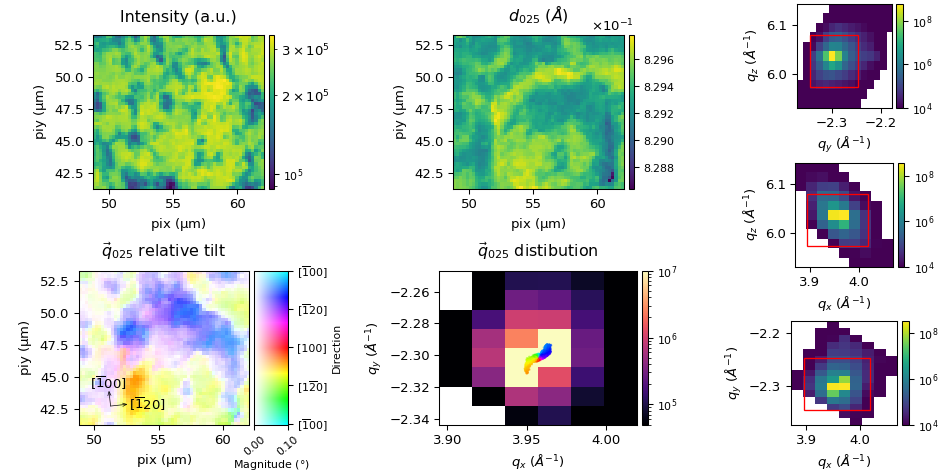

In [49]:
fig = plt.figure(figsize=(10, 5), layout="constrained", dpi=95)
subfigs = fig.subfigures(1, 2, wspace=None, width_ratios=[3, 1])

########################
### Local parameters ###
########################

# figure init
titles = [
    r"Intensity (a.u.)",
    fr"$d_{{{peak_index}}}~(\AA)$",
    fr"$\vec{{q}}_{{{peak_index}}}$ relative tilt",
    fr"$\vec{{q}}_{{{peak_index}}}$ distibution",
]

ax = subfigs[0].subplots(2, 2).flatten()

pi_ext = [pix[pi_win].min(), pix[pi_win].max(), piy[pi_win].min(), piy[pi_win].max()]

# plots
ax[0].imshow(
    roi_int[pi_win], extent=pi_ext, cmap="viridis", norm=LogNorm(), origin="lower"
)
ax[1].imshow(d[pi_win], extent=pi_ext, cmap="viridis", origin="lower")
ax[2].imshow(tilt[pi_win], extent=pi_ext, cmap="hsv", origin="lower")

qxr, qyr, qzr = roi_qcoords
qext = [qxr.min(), qxr.max(), qyr.min(), qyr.max()]

ax[3].imshow(
    qspace_avg_sliced.sum(2).T,
    extent=qext,
    norm=LogNorm(5e4, 1e7),
    cmap="magma",
    origin="lower",
)
ax[3].scatter(
    cx, cy, marker="o", s=0.5, c=azi_rel, cmap="hsv", alpha=0.5, vmin=-180, vmax=180
)

# normal colorbars
for a, t in zip(ax, titles):
    a.set_title(t, pad=10)
    if a != ax[2]:
        cbar = sxdm.plot.add_colorbar(a, a.get_images()[0])
        try:
            cbar.ax.ticklabel_format(scilimits=(0, 0), useMathText=True)
        except:
            pass

# tilt colorbar
sxdm.plot.add_hsv_colorbar(inc_rel, ax[2], crystal_directions[::-1])

# labels
_ = [a.set_xlabel(r"pix $(\mathsf{\mu m})$") for a in ax[:3]]
_ = [a.set_ylabel(r"piy $(\mathsf{\mu m})$") for a in ax[:3]]

ax[3].set_ylabel(r"$q_y$ ($\AA^{-1}$)")
ax[3].set_xlabel(r"$q_x$ ($\AA^{-1}$)")

# more labels
_ = sxdm.plot.add_directions(
    ax[2],
    crystal_directions[1],
    crystal_directions[0],
    angle=-offsets['phi'],
)

###########################
### Projections and VOI ###
###########################

ax = subfigs[1].subplots(3, 1)

# draw the _roi as rectangles
_roi = [y for x in roi_qcoords for y in [x.min(), x.max()]]
r2 = R(
    (_roi[0], _roi[2]),
    _roi[1] - _roi[0],
    _roi[3] - _roi[2],
    edgecolor="r",
    facecolor="none",
    transform=ax[2].transData,
)  # xy
r1 = R(
    (_roi[0], _roi[4]),
    _roi[1] - _roi[0],
    _roi[5] - _roi[4],
    edgecolor="r",
    facecolor="none",
    transform=ax[1].transData,
)  # xz
r0 = R(
    (_roi[2], _roi[4]),
    _roi[3] - _roi[2],
    _roi[5] - _roi[4],
    edgecolor="r",
    facecolor="none",
    transform=ax[0].transData,
)  # yz

#  reciprocal space
_qext = sxdm.utils.get_q_extents(qx, qy, qz)
for i, r in zip(range(3), [r0, r1, r2]):
    ax[i].imshow(
        qspace_avg.sum(i).T,
        extent=_qext[i],
        origin="lower",
        aspect="equal",
        norm=LogNorm(1e4),
    )
    ax[i].add_patch(r)
    cbar = sxdm.plot.add_colorbar(ax[i], ax[i].get_images()[0], size="7%")

# labels etc.
ax[0].set_xlabel(r"$q_y~(\AA^{-1})$")
ax[2].set_ylabel(r"$q_y~(\AA^{-1})$")

for i in (1, 2):
    ax[i].set_xlabel(r"$q_x~(\AA^{-1})$")

for i in (0, 1):
    ax[i].set_ylabel(r"$q_z~(\AA^{-1})$")

```{note}
The `pix` and `piy` directions are rotated relative to $q_x$ and $q_y$ by the $\phi$ angular offsets, i.e. `angles["phi"]`
```

### Interactive plot

Inspect interactively:

In [51]:
plt.close('all')

results = {
    "int": np.log(roi_int),
    "interplanar_distance": d,
    "tilt": tilt,
    "tilt_magnitude": inc_rel,
    "tilt_azimuth": azi_rel,
}

viz = sxdm.widgets.xsocs.Inspect5DQspace(
    results,
    path_qspace,
    relim_int=True,
    init_idx=[20, 20],
    projections="1d",
    coms=[cx, cy, cz],
    qspace_roi=roi_slice,
    mask_reciprocal=mask_reciprocal
)

viz.ax[0, 0].get_images()[0].set_cmap("viridis")
viz.fig.set_figwidth(8)
viz.fig.set_figheight(5)
viz.fig.subplots_adjust(top=.99, hspace=.3)
viz._iflog.value = True

viz.ax[1,1].axvline(cx0, lw=0.7, ls='--', c='k')
viz.ax[1,1].axhline(cy0, lw=0.7, ls='--', c='k')

viz.show()

### Clean plot

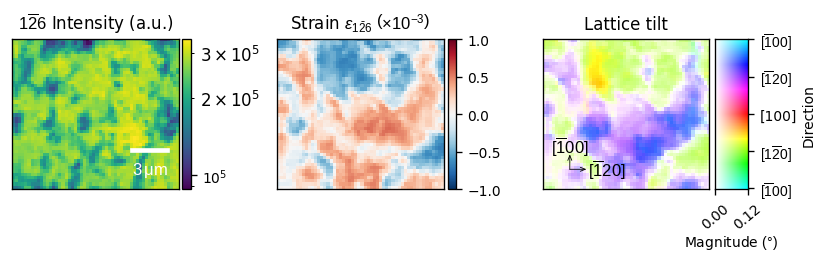

In [48]:
plt.close("all")
%matplotlib inline

pi_ext_masked = [
    pix[pi_win].min(),
    pix[pi_win].max(),
    piy[pi_win].min(),
    piy[pi_win].max(),
]

fig, ax = plt.subplots(
    1,
    3,
    figsize=(7, 3),
    sharex=True,
    sharey=True,
    layout="tight",
    gridspec_kw={"width_ratios": [1, 1, 1.15]},
    dpi=120,
)

ax[0].imshow(roi_int[pi_win], norm=LogNorm())
ax[0].set_title("$1\overline{2}6$ Intensity (a.u.)", fontsize="medium")

ax[1].imshow(strain[pi_win] * 1e3, cmap="RdBu_r", clim=[-1, 1])
ax[1].set_title(
    r"Strain $\epsilon_{1\bar{2}6}~\left(\times 10^{-3}\right)$", fontsize="medium"
)

ax[2].imshow(tilt[*pi_win, slice(None, None, None)],)
ax[2].set_title("Lattice tilt", fontsize="medium")

for a in ax:
    a.get_images()[0].set_extent(pi_ext_masked)

    a.set_xticks([])
    a.set_yticks([])

    if a == ax[2]:
        cbar = sxdm.plot.add_hsv_colorbar(inc_rel, a, crystal_directions[::-1])
    else:
        cbar = sxdm.plot.add_colorbar(a, a.get_images()[0], pad=0.03, size="5%")

scalebar_size = 3  # in um
sxdm.plot.add_scalebar(
    ax[0],
    h_size=scalebar_size,
    v_size=0.25,
    label=f"${scalebar_size}\,\mathrm{{\mu m}}$",
    color='w',
)

sxdm.plot.add_directions(
    ax[2],
    crystal_directions[1],
    crystal_directions[0],
    pad=0
)